In [213]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### OECD
https://data.oecd.org/
- "Value added in financial and insurance activities": "DV_VA"
- "General government net lending": "IV_lending"
- "Real effective exchange rates": "C_REER"
- "CPI: all items": "C_cpi"

- "Gross domestic product (output approach)": "C_gdp"

### WB
https://databank.worldbank.org/home.aspx
- "Foreign direct investment, net outflows (% of GDP)": "IV_fdi_outflow"
- "Net trade in goods and services (BoP, current US$)": "IV_trade_balance"
- "Broad money (% of GDP)": "C_M2"

### GDD 
https://www.imf.org/external/datamapper/datasets/GDD
- "nfc_ls"(houshold debt, loans and debt securities, % of GDP): "DV_nfc_ls"
- "hh_ls"(nonfinancial corporate debt, loans and debt securities, % of GDP): "DV_hh_ls"

### Historical Puclic Finance 
https://www.imf.org/external/np/fad/histdb/index.htm
- "exp"(government expenditure, % of GDP): "IV_gov_exp"

### WID
https://wid.world/data/
- "gini": "IV_gini"

In [214]:
# import OECD.csv and select features
oecd = pd.read_csv('data_source/OECD.csv')

oecd = oecd.loc[(oecd['Subject']=='Value added in financial and insurance activities')
                |(oecd['Subject']=='General government net lending')
                |(oecd['Subject']=='Real effective exchange rates')
                |(oecd['Subject']=='CPI: all items')]

oecd = oecd[['Subject','Country','Year','Value']]

In [215]:
# import gdp.csv/OECD
gdp = pd.read_csv('data_source/gdp.csv')
gdp = gdp.loc[gdp['MEASURE']=='VXVOB']
gdp = gdp[['Transaction','Country','Year','Value']]
gdp = gdp.rename(columns={'Transaction':'Subject'})

In [216]:
def wb_clean(df):
    # drop unnecessary columns
    df = df.drop(['Unnamed: 0', 'Country Code', 'Indicator Code', 'V65'], axis=1)
    # change from wide to long format
    df = df.pivot_table(index='Country Name', columns='Indicator Name').unstack().reset_index()
    # rename columns
    df = df.rename(columns={'level_0':'Year', 'Indicator Name':'Subject',
                                       'Country Name':'Country', 0:'Value'})
    convert_dict = {'Year': int, 
                'Value': float
               } 
  
    df = df.astype(convert_dict)
    df['Country'] = df['Country'].str.replace('Russian Federation', 'Russia')
    df['Country'] = df['Country'].str.replace('Korea, Rep.', 'Korea')
    df['Country'] = df['Country'].str.replace('China', "China (People's Republic of)")
    
    return df

In [217]:
fdi_outflow = pd.read_csv('data_source/outflow.csv')
fdi_outflow = wb_clean(fdi_outflow)

trade_balance = pd.read_csv('data_source/netgoodservices.csv')
trade_balance = wb_clean(trade_balance)

m2 = pd.read_csv('data_source/broad_money.csv')
m2 = wb_clean(m2)

<ipython-input-216-1164f411f506>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Country'] = df['Country'].str.replace('Korea, Rep.', 'Korea')
<ipython-input-216-1164f411f506>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Country'] = df['Country'].str.replace('Korea, Rep.', 'Korea')
<ipython-input-216-1164f411f506>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Country'] = df['Country'].str.replace('Korea, Rep.', 'Korea')


In [218]:
oecd = oecd.append([gdp,fdi_outflow, trade_balance, m2])
oecd = oecd.sort_values(by=['Country', 'Subject', 'Year'])
oecd = oecd.pivot_table(values='Value', index=['Country', 'Year'], columns=['Subject']).reset_index()

In [219]:
gdd = pd.read_csv('data_source/global_debt_database.csv')
gdd = gdd[['country', 'year', 'nfc_ls', 'hh_ls']]

def gdd_clean(df):
    # rename columns
    df = df.rename(columns={'year':'Year', 'country':'Country'})
    # change country name
    df['Country'] = df['Country'].str.replace('Russian Federation', 'Russia')
    df['Country'] = df['Country'].str.replace('Korea, Republic of', 'Korea')
    df['Country'] = df['Country'].str.replace('China, Mainland', "China (People's Republic of)")
    
    # replace 0 with NAs
    df.replace(0, np.nan, inplace=True)
    
    return df
gdd = gdd_clean(gdd)
oecd = pd.merge(oecd, gdd, on=['Country', 'Year'], how='outer')

In [220]:
public_finance = pd.read_csv('data_source/historical_public_finance_dataset.csv')
public_finance = public_finance[['country', 'year', 'exp']]

# clean public_finance dataframe
def public_finance_clean(df):
    # rename columns
    df = df.rename(columns={'year':'Year', 'country':'Country'})
    
    # change country name
    df['Country'] = df['Country'].str.replace('Russian Federation', 'Russia')
    df['Country'] = df['Country'].str.replace('South Korea', 'Korea')
    df['Country'] = df['Country'].str.replace('China', "China (People's Republic of)")
    
    # replace 0 with NAs
    df.replace(0, np.nan, inplace=True)
    
    return df
public_finance = public_finance_clean(public_finance)
oecd = pd.merge(oecd, public_finance, on=['Country', 'Year'], how='outer')

In [221]:
gini = pd.read_csv('data_source/gini.csv')
gini = gini[['V1', 'V4', 'V5']]

def gini_clean(df):
    # rename columns
    df = df.rename(columns={'V4':'Year', 'V1':'Country', 'V5':'gini'})
    
    # change country name
    df['Country'] = df['Country'].str.replace('South Korea', 'Korea')
    df['Country'] = df['Country'].str.replace('China', "China (People's Republic of)")
    
    # replace 0 with NAs
    df.replace(0, np.nan, inplace=True)
    
    return df
gini = gini_clean(gini)
oecd = pd.merge(oecd, gini, on=['Country', 'Year'], how='outer')

In [222]:
oecd = oecd.rename(columns={
    "Value added in financial and insurance activities": "DV_VA",
    "nfc_ls": "DV_nfc_ls",
    "hh_ls": "DV_hh_ls",
    "General government net lending": "IV_lending",
    "exp": "IV_gov_exp",
    "gini": "IV_gini",
    "Net trade in goods and services (BoP, current US$)": "IV_trade_balance",
    "Foreign direct investment, net outflows (% of GDP)": "IV_fdi_outflow",
    "Real effective exchange rates": "C_REER",
    "CPI: all items": "C_cpi",
    "Gross domestic product (output approach)": "C_gdp",
    "Broad money (% of GDP)": "C_M2"
})

In [223]:
oecd.Country.nunique()

277

In [224]:
oecd.isnull().sum()

Country                 0
Year                    0
C_M2                15939
C_cpi               23424
IV_fdi_outflow      15600
IV_lending          24573
C_gdp               23501
IV_trade_balance    18973
C_REER              23894
DV_VA               24406
DV_nfc_ls           23402
DV_hh_ls            23387
IV_gov_exp          20093
IV_gini             24730
dtype: int64

In [225]:
#country_ls = ['Australia', 'Brazil', 'Canada', 'Chile', "China (People's Republic of)", 
            'Denmark', 'Hungary', 'Iceland', 'Israel', 'Japan', 'Korea', 'Mexico', 
            'New Zealand', 'Norway', 'Poland', 'South Africa', 'Sweden', 'Switzerland', 
            'Turkey', 'United Kingdom', 'United States']
#oecd = oecd[oecd.Country.isin(country_ls)] 

IndentationError: unexpected indent (<ipython-input-225-d16b2d9b4e29>, line 2)

In [226]:
oecd.describe()

,Year,C_M2,C_cpi,IV_fdi_outflow,IV_lending,C_gdp,IV_trade_balance,C_REER,DV_VA,DV_nfc_ls,DV_hh_ls,IV_gov_exp,IV_gini
count,25573.000000,9634.000000,2149.000000,9973.000000,1000.000000,2.072000e+03,6.600000e+03,1679.000000,1167.000000,2171.000000,2186.000000,5480.000000,843.000000
mean,1949.283424,46.381157,17.176366,2.853186,-2.103180,1.567590e+06,1.276802e+09,113.516314,5.759766,65.066879,36.104242,20.224061,0.474866
std,60.055604,35.364012,111.786620,30.592270,4.066963,4.860346e+06,3.971697e+10,109.867716,3.669052,51.404398,29.266453,14.209101,0.117940
min,1800.000000,2.857408,-7.633931,-89.616745,-32.061638,6.644201e+03,-7.617150e+11,31.343123,1.504824,0.067251,0.084322,0.684444,0.123687
25%,1914.000000,22.897870,2.000158,0.122237,-4.224411,1.161012e+05,-1.219039e+09,93.540402,3.987677,30.017793,11.539898,9.399695,0.393227
50%,1970.000000,35.911524,3.805866,0.647694,-2.371919,2.793465e+05,-1.591229e+08,101.711250,4.910704,56.490852,29.929266,16.078400,0.447517
75%,1995.000000,59.022905,8.669271,1.943356,0.050139,9.459981e+05,3.404986e+08,110.601125,6.278231,87.879648,53.671208,27.861013,0.549043
max,2019.000000,395.672004,2947.733000,1846.596366,18.671370,4.887260e+07,4.830940e+11,2458.322000,29.643030,569.084027,139.426459,71.841200,0.738630


In [227]:
# get DV's percentage change 
oecd['DV_VAplus'] = oecd['DV_VA'].pct_change()
oecd['DV_nfc_lsplus'] = oecd['DV_nfc_ls'].pct_change()
oecd['DV_hh_lsplus'] = oecd['DV_hh_ls'].pct_change()

# get lag 1 period of DV 
oecd['IVlag1_DV_VAplus'] = oecd['DV_VAplus'].shift(1)
oecd['IVlag1_DV_nfc_lsplus'] = oecd['DV_nfc_lsplus'].shift(1)
oecd['IVlag1_DV_hh_lsplus'] = oecd['DV_hh_lsplus'].shift(1)

In [228]:
# get IV's percentage change
oecd['IV_lendingplus'] = oecd['IV_lending'].pct_change()
oecd['IV_gov_expplus'] = oecd['IV_gov_exp'].pct_change()
oecd['IV_trade_balanceplus'] = oecd['IV_trade_balance'].pct_change()
oecd['IV_fdi_outflowplus'] = oecd['IV_fdi_outflow'].pct_change()

# get lag 1 period and 2 periods of IV
oecd['IV_lendingplus_lag1'] = oecd['IV_lendingplus'].shift(1)
oecd['IV_gov_expplus_lag1'] = oecd['IV_gov_expplus'].shift(1)
oecd['IV_trade_balanceplus_lag1'] = oecd['IV_trade_balanceplus'].shift(1)
oecd['IV_fdi_outflowplus_lag1'] = oecd['IV_fdi_outflowplus'].shift(1)

oecd['IV_lendingplus_lag2'] = oecd['IV_lendingplus'].shift(2)
oecd['IV_gov_expplus_lag2'] = oecd['IV_gov_expplus'].shift(2)
oecd['IV_trade_balanceplus_lag2'] = oecd['IV_trade_balanceplus'].shift(2)
oecd['IV_fdi_outflowplus_lag2'] = oecd['IV_fdi_outflowplus'].shift(2)

In [229]:
# get CV's percentage change
#oecd['C_NFLplus'] = oecd['C_NFL'].pct_change()
oecd['C_REERplus'] = oecd['C_REER'].pct_change()
oecd['C_cpiplus'] = oecd['C_cpi'].pct_change()
oecd['C_gdpplus'] = oecd['C_gdp'].pct_change()
oecd['C_m2plus'] = oecd['C_M2'].pct_change()

In [230]:
# get log of C_gdp and IV_trade_balance
oecd['C_gdp_log'] = np.log(oecd['C_gdp'])
#oecd['IV_trade_balance_log'] = np.log(oecd['IV_trade_balance'])

In [232]:
oecd.to_csv('data_processing/financialization_df.csv')

In [231]:
oecd.describe()

,Year,C_M2,C_cpi,IV_fdi_outflow,IV_lending,C_gdp,IV_trade_balance,C_REER,DV_VA,DV_nfc_ls,...,IV_fdi_outflowplus_lag1,IV_lendingplus_lag2,IV_gov_expplus_lag2,IV_trade_balanceplus_lag2,IV_fdi_outflowplus_lag2,C_REERplus,C_cpiplus,C_gdpplus,C_m2plus,C_gdp_log
count,25573.000000,9634.000000,2149.000000,9973.000000,1000.000000,2.072000e+03,6.600000e+03,1679.000000,1167.000000,2171.000000,...,25492.0,25151.000000,25289.000000,25551.000000,25491.0,25151.000000,2.517300e+04,25247.000000,25572.000000,2072.000000
mean,1949.283424,46.381157,17.176366,2.853186,-2.103180,1.567590e+06,1.276802e+09,113.516314,5.759766,65.066879,...,NaN,-0.038556,0.004613,0.060091,NaN,0.001273,-3.855728e+09,0.019837,0.007644,12.676132
std,60.055604,35.364012,111.786620,30.592270,4.066963,4.860346e+06,3.971697e+10,109.867716,3.669052,51.404398,...,NaN,4.327489,0.103506,25.681369,NaN,0.153266,6.117499e+11,2.149751,0.116716,1.676726
min,1800.000000,2.857408,-7.633931,-89.616745,-32.061638,6.644201e+03,-7.617150e+11,31.343123,1.504824,0.067251,...,-inf,-658.657206,-0.948290,-885.134740,-inf,-0.694444,-9.706025e+13,-0.996019,-0.951708,8.801500
25%,1914.000000,22.897870,2.000158,0.122237,-4.224411,1.161012e+05,-1.219039e+09,93.540402,3.987677,30.017793,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,11.662216
50%,1970.000000,35.911524,3.805866,0.647694,-2.371919,2.793465e+05,-1.591229e+08,101.711250,4.910704,56.490852,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,12.540205
75%,1995.000000,59.022905,8.669271,1.943356,0.050139,9.459981e+05,3.404986e+08,110.601125,6.278231,87.879648,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,13.759995
max,2019.000000,395.672004,2947.733000,1846.596366,18.671370,4.887260e+07,4.830940e+11,2458.322000,29.643030,569.084027,...,inf,58.667003,5.047934,3699.181534,inf,22.359511,8.787746e+02,330.776761,5.711645,17.704728


In [198]:
#convert year to datetime
oecd['Year'] = pd.to_datetime(oecd['Year'], format='%Y')
#add column year to index
df = oecd.set_index('Year', append=True)
#swap indexes
df.index = df.index.swaplevel(0,1)

In [200]:
def pooled_ols(exog_vars, dv):
    exog = sm.add_constant(df[exog_vars])
    mod = PooledOLS(df.dv, exog)
    pooled_res = mod.fit()
    print(pooled_res)
    
    return pooled_res

In [199]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm

exog_vars = ["IV_lending", "IV_gini", "IV_trade_balance_log", "C_gdp_log", "C_REER", "C_M2", "C_cpi"]
exog = sm.add_constant(df[exog_vars])
mod = PooledOLS(df.DV_VA, exog)
pooled_res = mod.fit()
print(pooled_res)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooled_res.predict().fitted_values
residuals_pooled_OLS = pooled_res.resids

                          PooledOLS Estimation Summary                          
Dep. Variable:                  DV_VA   R-squared:                        0.2473
Estimator:                  PooledOLS   R-squared (Between):             -0.1884
No. Observations:                 226   R-squared (Within):               0.2737
Date:                Sat, Apr 17 2021   R-squared (Overall):              0.2473
Time:                        21:07:09   Log-likelihood                   -510.40
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      10.230
Entities:                          26   P-value                           0.0000
Avg Obs:                       8.6923   Distribution:                   F(7,218)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic (robust):             10.230
                            

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


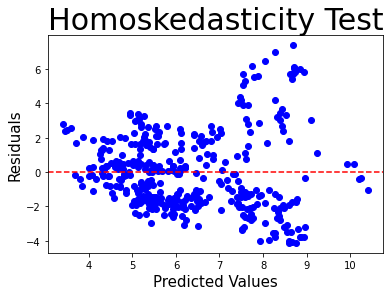

In [142]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = "blue")
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel("Predicted Values", fontsize = 15)
ax.set_ylabel("Residuals", fontsize = 15)
ax.set_title("Homoskedasticity Test", fontsize = 30)
plt.show()

In [180]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([df, residuals_pooled_OLS], axis=1)

exog_fill = exog.fillna(0)
white_test_results = het_white(pooled_OLS_dataset["residual"], exog_fill)
labels = ["LM-Stat", "LM p-val", "F-Stat", "F p-val"] 
print(dict(zip(labels, white_test_results)))
# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset["residual"], exog_fill)
labels = ["LM-Stat", "LM p-val", "F-Stat", "F p-val"] 
print(dict(zip(labels, breusch_pagan_test_results)))

AssertionError: 

In [190]:
# Perform FE
from linearmodels import PanelOLS
mod = PanelOLS(df.DV_VA, exog)
fe_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  DV_VA   R-squared:                        0.2473
Estimator:                   PanelOLS   R-squared (Between):             -0.1884
No. Observations:                 226   R-squared (Within):               0.2737
Date:                Sat, Apr 17 2021   R-squared (Overall):              0.2473
Time:                        20:56:43   Log-likelihood                   -510.40
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.230
Entities:                          26   P-value                           0.0000
Avg Obs:                       8.6923   Distribution:                   F(7,218)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic (robust):             52.140
                            

In [191]:
# Perform RE
from linearmodels import RandomEffects
mod = RandomEffects(df.DV_VA, exog)
re_res = mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  DV_VA   R-squared:                        0.2473
Estimator:              RandomEffects   R-squared (Between):             -0.1884
No. Observations:                 226   R-squared (Within):               0.2737
Date:                Sat, Apr 17 2021   R-squared (Overall):              0.2473
Time:                        20:56:49   Log-likelihood                   -510.40
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      10.230
Entities:                          26   P-value                           0.0000
Avg Obs:                       8.6923   Distribution:                   F(7,218)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic (robust):             10.230
                            